# Transfer Learning avec le modèle de classification pré-entraîné VGG16

Dans ce Notebook, nous essayons d'entraîner un modèle VGG16 pour la classification des images de notre dataset Garbage. 5 modèles en tout ont été testés. 

Aucune GridSearch n'a été appliquée encore pour trouver les meilleurs hyper-paramètres. Cette stratégie sera utilisée une fois que nous aurons testé d'autres modèles pré-entraînés (VGG19, ResNet50, DenseNet...).

Imports des bibliothèques pour le projet

In [ ]:
import time
import itertools
import os
import numpy as np
import pandas as pd

"""
plot de graphes
"""
import matplotlib.pyplot as plt

"""
Création et gestion des modèles de classification d'images avec Keras
"""
from tensorflow import keras

#Accès aux images à classifier, qui sont réparties dans différents dossiers
from keras.preprocessing.image import ImageDataGenerator

#Différents types de couches pour les CNN
from keras.layers import Flatten, Dense, Activation

#Création de l'architecture des modèles avec Model
from keras.models import Model 

#Affichage de l'architecture des modèle
#from keras.utils.vis_utils import plot_model

#Gestion des arrêtes anticipés
from keras.callbacks import EarlyStopping

"""
Utilisation du modèle VGG16
"""
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

"""
Mesures de performance des modèles avec Sklearn
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set up : fonctions utiles et initialisation

In [ ]:
def plot_accuracy_loss(history):
    """
    Retourne 2 graphes : un qui présente l'accuracy sur les sets de train et validation et le deuxième avec la loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    #Accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    ax1.plot(range(len(accuracy)), accuracy, label='train')
    ax1.plot(range(len(val_accuracy)), val_accuracy, label='validation')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    #Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(range(len(loss)), loss, label='train')
    ax2.plot(range(len(val_loss)), val_loss, label='validation')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Affiche la matrice de confusion du modèle sur les données de test
    """
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def study_model(model, classes, test_generator, executionTime, plot_cm=False):
    """
    Retourne des informations sur la performance du modèle
    """

    #Durée d'entraînement
    print(f"Durée d'entraînement : {round(executionTime, 2)} secondes")

    #Performances sur le set de test
    preds = model.predict(test_generator)  # preds are proba for each class
    preds_classes = [i.argmax() for i in preds]
    y_true = test_generator.classes
    acc_test = accuracy_score(y_true, preds_classes)
    prec_test = precision_score(y_true, preds_classes, average='weighted')
    rec_test = recall_score(y_true, preds_classes, average='weighted')
    f1_test = f1_score(y_true, preds_classes, average='weighted')
    results = pd.DataFrame([[acc_test, prec_test, rec_test, f1_test]], columns=['accuracy', 'precision', 'recall', 'f1-score'])
    print("\nPerformances sur le set de test : \n")
    print(results)

    #Matrice de confusion
    if (plot_cm):
      cm = confusion_matrix(y_true, preds_classes)
      plot_confusion_matrix(cm, classes)

In [ ]:
#infos du dataset
labels = os.listdir("./Garbage classification")
nClasses = len(labels) #6
inputFolder = "./Garbage_train_test_val"

#Utilisation de VGG16 : format d'images accepté = (224,224)
modelName = "VGG16"
img_width = 224
img_height = 224

#Hyper-paramètres
batch_size = 32
epochs_nb = 50

#Création des générateurs
train_datagen   =  ImageDataGenerator(preprocessing_function = preprocess_vgg16)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_vgg16)
train_generator = train_datagen.flow_from_directory(directory=r'./{}/train'.format(inputFolder),target_size=(img_width, img_height),color_mode='rgb',batch_size=batch_size,class_mode='categorical',shuffle=True,seed=42)
test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),target_size=(img_width, img_height),color_mode='rgb',batch_size=batch_size,class_mode='categorical',shuffle=False)
validation_generator = test_datagen.flow_from_directory(directory=r'./{}/val'.format(inputFolder),target_size=(img_width, img_height),color_mode='rgb',batch_size=batch_size,class_mode='categorical',shuffle=False)

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


# Modèle 1

Nous téléchargeons le modèle **VGG16 pré-entraîné sur ImageNet** et ne modifions que la partie classification (correspondant aux couches entièrements connectées). Les poids des couches convolutives de VGG16 sont donc conservées (layer.trainable = False).

In [ ]:
def VGG16_Architecture(img_width, img_height, nClasses):
  
  model = VGG16(include_top = False, weights = 'imagenet', input_shape = (img_width, img_height, 3))
  
  #Partie convolutive : on garde les paramètres des couches de VGG16 entraîné sur imagenet
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on ajoute une couche entièrement connectée ainsi que la dernière avec le bon nombre de classes
  #Seule cette partie sera entraînée par le modèle
  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

In [ ]:
#Création et compilation du modèle
model = VGG16_Architecture(img_width, img_height, nClasses)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
startTime=time.time()
history = model.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/50
56/56 [==============================] - 41s 517ms/step - loss: 4.6425 - accuracy: 0.4734 - val_loss: 3.2489 - val_accuracy: 0.5889
Epoch 2/50
56/56 [==============================] - 18s 313ms/step - loss: 0.8204 - accuracy: 0.8386 - val_loss: 2.7944 - val_accuracy: 0.6233
Epoch 3/50
56/56 [==============================] - 17s 310ms/step - loss: 0.1412 - accuracy: 0.9649 - val_loss: 2.5779 - val_accuracy: 0.6711
Epoch 4/50
56/56 [==============================] - 17s 310ms/step - loss: 0.0231 - accuracy: 0.9943 - val_loss: 2.5816 - val_accuracy: 0.6817
Epoch 5/50
56/56 [==============================] - 17s 305ms/step - loss: 0.0172 - accuracy: 0.9983 - val_loss: 2.4622 - val_accuracy: 0.6923
Epoch 6/50
56/56 [==============================] - 17s 305ms/step - loss: 0.0190 - accuracy: 0.9977 - val_loss: 2.4620 - val_accuracy: 0.7162
Epoch 7/50
56/56 [==============================] - 17s 308ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 2.4208 - val_accuracy: 0.7321

In [ ]:
study_model(model, labels, test_generator, executionTime)

Durée d'entraînement : 893.78 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.739583   0.742118  0.739583  0.733886


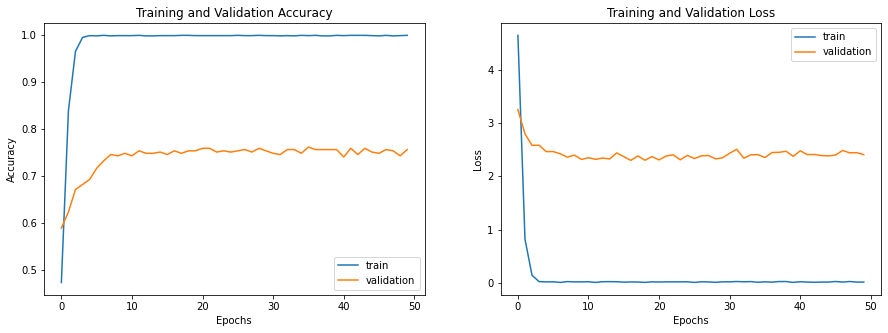

In [ ]:
plot_accuracy_loss(history)

L'entraînement a duré 15min avec le GPU de Google Colab.

L'accuracy obtenue sur le set de test est de presque 74%.

On remarque nettement un **surapprentissage** à partir de la 10ème epoch environ. En effet, l'accuracy sur le train set atteint les 100% tandis que sur le set de validation celle-ci stagne à 75%.

De même, en observant la validation loss, on remarque qu'elle remonte à partir de la 10ème epoch environ, ce qui démontre un surapprentissage.

# Modèle 2 : modification de l'optimiseur

un autre optimizer : Adam

In [ ]:
#Création et compilation du modèle
model2 = VGG16_Architecture(img_width, img_height, nClasses)
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=2e-5), metrics=['accuracy'])

In [ ]:
startTime=time.time()
history = model2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/50
56/56 [==============================] - 18s 307ms/step - loss: 5.1113 - accuracy: 0.4513 - val_loss: 3.1250 - val_accuracy: 0.6074
Epoch 2/50
56/56 [==============================] - 17s 297ms/step - loss: 0.6897 - accuracy: 0.8601 - val_loss: 2.5462 - val_accuracy: 0.6472
Epoch 3/50
56/56 [==============================] - 17s 298ms/step - loss: 0.1145 - accuracy: 0.9711 - val_loss: 2.4609 - val_accuracy: 0.6499
Epoch 4/50
56/56 [==============================] - 17s 298ms/step - loss: 0.0265 - accuracy: 0.9949 - val_loss: 2.4399 - val_accuracy: 0.6525
Epoch 5/50
56/56 [==============================] - 17s 297ms/step - loss: 0.0112 - accuracy: 0.9989 - val_loss: 2.4222 - val_accuracy: 0.6525
Epoch 6/50
56/56 [==============================] - 17s 295ms/step - loss: 0.0144 - accuracy: 0.9983 - val_loss: 2.4013 - val_accuracy: 0.6472
Epoch 7/50
56/56 [==============================] - 17s 301ms/step - loss: 0.0151 - accuracy: 0.9983 - val_loss: 2.4097 - val_accuracy: 0.6525

In [ ]:
study_model(model2, labels, test_generator, executionTime)

Durée d'entraînement : 849.12 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.677083   0.676145  0.677083  0.675381


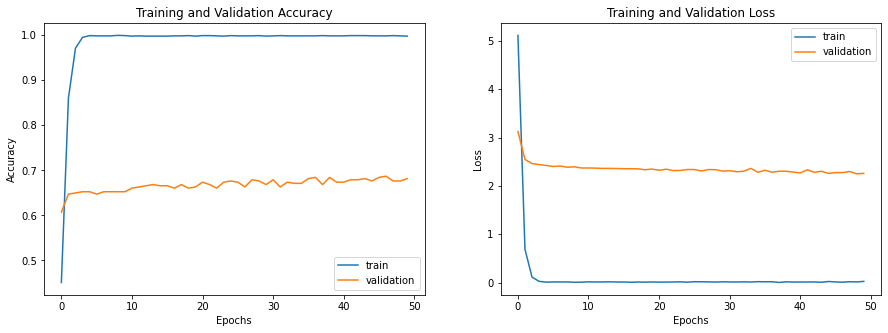

In [ ]:
plot_accuracy_loss(history)

Nous remarquons que changer l'optimiseur n'a pas résolu le problème du surapprentissage. 

Les résultats sont même moins bons qu'avec le modèle précédent (67,7% d'accuracy sur le test set).

# Modèle 3 : architecture moins profonde

En réduisant le nombre de neurones sur la couche entièrement connectée de notre modèle, nous pouvons diminuer le risque de surapprentissage car le modèle contiendra moins de paramètres.

In [ ]:
def VGG16_Architecture_2(img_width, img_height, nClasses):
  
  model = VGG16(include_top = False, weights = 'imagenet', input_shape = (img_width, img_height, 3))
  
  #Partie convolutive : on garde les paramètres des couches de VGG16 entraîné sur imagenet
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on diminue le nombre de neurones afin de réduire les risques d'overfitting
  x = Dense(128)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

In [ ]:
model3 = VGG16_Architecture_2(img_width, img_height, nClasses)
model3.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
startTime=time.time()
history = model3.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/50
56/56 [==============================] - 18s 308ms/step - loss: 5.1844 - accuracy: 0.4020 - val_loss: 3.3093 - val_accuracy: 0.5623
Epoch 2/50
56/56 [==============================] - 18s 313ms/step - loss: 1.2916 - accuracy: 0.7605 - val_loss: 2.6303 - val_accuracy: 0.6393
Epoch 3/50
56/56 [==============================] - 17s 299ms/step - loss: 0.3352 - accuracy: 0.9162 - val_loss: 2.4940 - val_accuracy: 0.6340
Epoch 4/50
56/56 [==============================] - 17s 294ms/step - loss: 0.0680 - accuracy: 0.9841 - val_loss: 2.3403 - val_accuracy: 0.6764
Epoch 5/50
56/56 [==============================] - 17s 297ms/step - loss: 0.0176 - accuracy: 0.9972 - val_loss: 2.2277 - val_accuracy: 0.6844
Epoch 6/50
56/56 [==============================] - 17s 295ms/step - loss: 0.0079 - accuracy: 0.9989 - val_loss: 2.2067 - val_accuracy: 0.7056
Epoch 7/50
56/56 [==============================] - 17s 296ms/step - loss: 0.0112 - accuracy: 0.9983 - val_loss: 2.1986 - val_accuracy: 0.7241

In [ ]:
study_model(model3, labels, test_generator, executionTime)

Durée d'entraînement : 847.09 secondes

Performances sur le set de test : 

   accuracy  precision   recall  f1-score
0   0.71875   0.720777  0.71875  0.718164


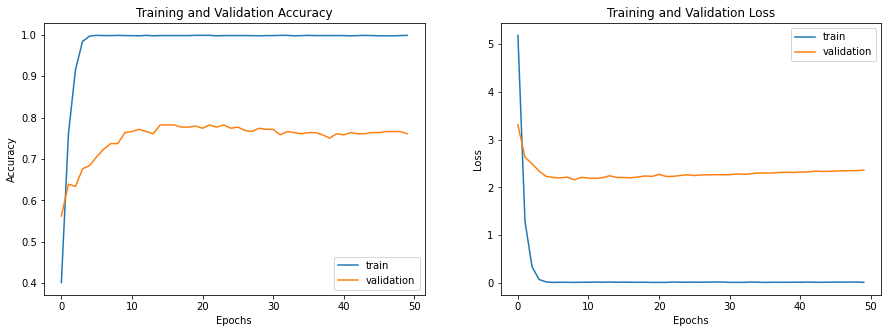

In [ ]:
plot_accuracy_loss(history)

Avec une architecture moins profonde, les performances semblent légèrement meilleures sur le set de validation mais elles sont moins bonnes sur le set de test. Le surapprentissage est toujours présent.

Afin de palier ce problème, nous devons appliquer une **stratégie d'augmentation de données**. 

# Modèle 4 : avec augmentation de données

Les transformations que nous appliquons à l'image sont : décalage en largeur et hauteur, retournement horizontal et vertical, rotations, modification de luminosité et zoom. 

Ces transformations ont été testées préalablement sur les images du dataset (cf le notebook Data_Visualization.ipynb).

In [ ]:
train_datagen_da = ImageDataGenerator(preprocessing_function = preprocess_vgg16,
                                      width_shift_range=0.2, 
                                      height_shift_range=0.2, 
                                      horizontal_flip=True, 
                                      vertical_flip=True,
                                      rotation_range = 90,
                                      brightness_range = [0.8, 1.2],
                                      zoom_range = [0.8, 1],
                                      fill_mode='nearest')

train_generator = train_datagen_da.flow_from_directory(directory=r'./{}/train'.format(inputFolder),target_size=(img_width, img_height),color_mode='rgb',batch_size=batch_size,class_mode='categorical',shuffle=True,seed=42)

Found 1766 images belonging to 6 classes.


In [ ]:
model4 = VGG16_Architecture(img_width, img_height, nClasses)
model4.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
startTime=time.time()
history = model4.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/50
56/56 [==============================] - 63s 900ms/step - loss: 4.9624 - accuracy: 0.4202 - val_loss: 3.4633 - val_accuracy: 0.5146
Epoch 2/50
56/56 [==============================] - 40s 717ms/step - loss: 3.0610 - accuracy: 0.5396 - val_loss: 3.0159 - val_accuracy: 0.5544
Epoch 3/50
56/56 [==============================] - 40s 718ms/step - loss: 2.4416 - accuracy: 0.6149 - val_loss: 2.1619 - val_accuracy: 0.6340
Epoch 4/50
56/56 [==============================] - 40s 715ms/step - loss: 2.1188 - accuracy: 0.6472 - val_loss: 1.8088 - val_accuracy: 0.6844
Epoch 5/50
56/56 [==============================] - 40s 713ms/step - loss: 1.5761 - accuracy: 0.6925 - val_loss: 1.6510 - val_accuracy: 0.7029
Epoch 6/50
56/56 [==============================] - 41s 729ms/step - loss: 1.6960 - accuracy: 0.6920 - val_loss: 1.5627 - val_accuracy: 0.7294
Epoch 7/50
56/56 [==============================] - 41s 722ms/step - loss: 1.4799 - accuracy: 0.7163 - val_loss: 1.3936 - val_accuracy: 0.7480

In [ ]:
study_model(model4, labels, test_generator, executionTime)

Durée d'entraînement : 2034.08 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.815104   0.816222  0.815104   0.81392


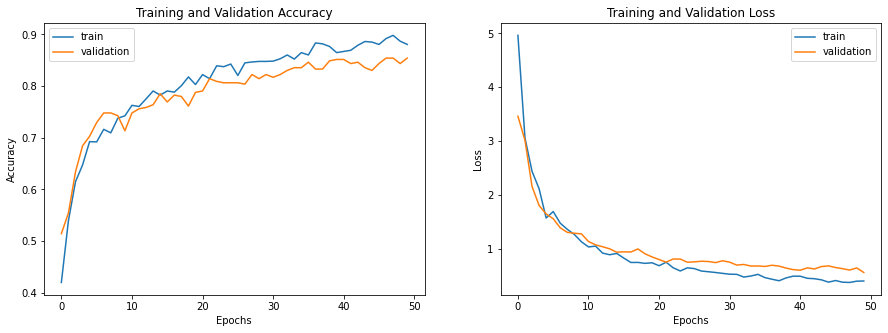

In [ ]:
plot_accuracy_loss(history)

**Temps d'exécution plus long**

L'entraînement a duré deux fois plus de temps que sur les autres modèles : dû au fait qu'il y a + d'images dans le set d'entraînement.

**Disparition du surapprentissage**

On remarque que l'overfitting a totalement disparu : les deux courbes d'accuracy entre le train et le validation set sont très proches l'une de l'autre. D'autre part, la loss est toujours en train de diminuer à la fin de la 50ème epoch.

**Meilleures performances**

Les performances sur le test set sont meilleures : l'accuracy est montée à plus de 81%.

**Absence de convergence**

Le modèle n'a pas totalement convergé : en effet l'accuracy monte encore lorsque l'on stoppe l'entraînement. Il faudrait entraîner ce modèle sur encore plus d'epochs.

# Modèle 5 : entraînement sur plus d'epochs

Cette fois-ci, le modèle est entraîné sur **80 epochs**.

On ajoute un **early stopping** afin de stopper l'entraînement lorsque la validation loss remonte. Si la validation loss cesse de diminuer sur plus de 10 epochs successives (*patience*=10), l'entraînement est stoppé.

In [ ]:
model5 = VGG16_Architecture(img_width, img_height, nClasses)
model5.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb_list=[es]
epochs_nb = 80

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
startTime=time.time()
history = model5.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator, callbacks=cb_list)
executionTime = (time.time() - startTime)

Epoch 1/80
56/56 [==============================] - 43s 744ms/step - loss: 5.0062 - accuracy: 0.4043 - val_loss: 3.7230 - val_accuracy: 0.5066
Epoch 2/80
56/56 [==============================] - 41s 723ms/step - loss: 3.1599 - accuracy: 0.5340 - val_loss: 2.6859 - val_accuracy: 0.6313
Epoch 3/80
56/56 [==============================] - 40s 714ms/step - loss: 2.3679 - accuracy: 0.6376 - val_loss: 2.2144 - val_accuracy: 0.6605
Epoch 4/80
56/56 [==============================] - 40s 709ms/step - loss: 2.0361 - accuracy: 0.6574 - val_loss: 2.0223 - val_accuracy: 0.6923
Epoch 5/80
56/56 [==============================] - 40s 706ms/step - loss: 1.8937 - accuracy: 0.6829 - val_loss: 1.8549 - val_accuracy: 0.7109
Epoch 6/80
56/56 [==============================] - 40s 707ms/step - loss: 1.5812 - accuracy: 0.7050 - val_loss: 1.8242 - val_accuracy: 0.7109
Epoch 7/80
56/56 [==============================] - 39s 699ms/step - loss: 1.4609 - accuracy: 0.7180 - val_loss: 1.5056 - val_accuracy: 0.7374

Early stopping à l'Epoch 67 : à partir de l'epoch 57, la validation loss a cessé de diminuer.

In [ ]:
study_model(model5, labels, test_generator, executionTime)

Durée d'entraînement : 2663.36 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.830729   0.834743  0.830729  0.830348


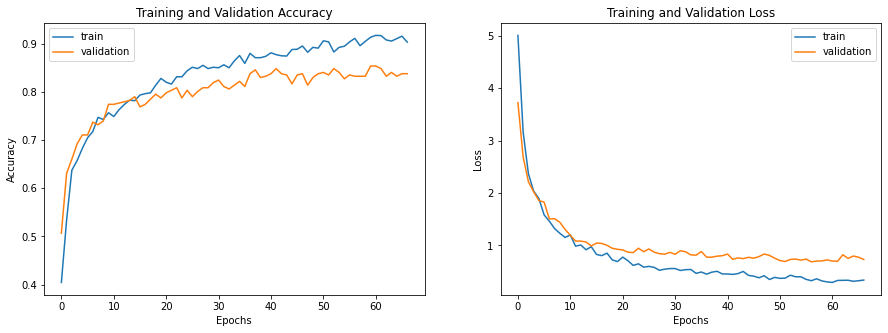

In [ ]:
plot_accuracy_loss(history)

In [ ]:
modelname = "vgg16_da_67"
model5.save(f'./Modeles/{modelname}.h5')

**Conclusion :**

En appliquant la méthode du Transfer Learning avec le modèle VGG16 sur notre dataset, ainsi qu'une stratégie d'augmentation de données, nous obtenons un modèle qui atteint les **83% d'accuracy** sur notre dataset de test.